# Fraud Detection

#### I will develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

## Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [2]:
#colormap and number
cmap = cm.get_cmap('YlGnBu',12) 
col_def =[]
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    col_def.append(rgb2hex(rgb))

## Loading the Data

In [3]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Inspecting the data

In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


There are three object type features namely "type", "nameOrig" and "nameDest". Now let's take a look at whether there are any missing values or not.

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

From the looks of it there are no missing values. From the Data Dictionary provided in the case study pdf it said that there are no records for customers that start with M(Merchants). Before that let us take a look at how data is with the help of EDA.

In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Exploratory Data Analysis

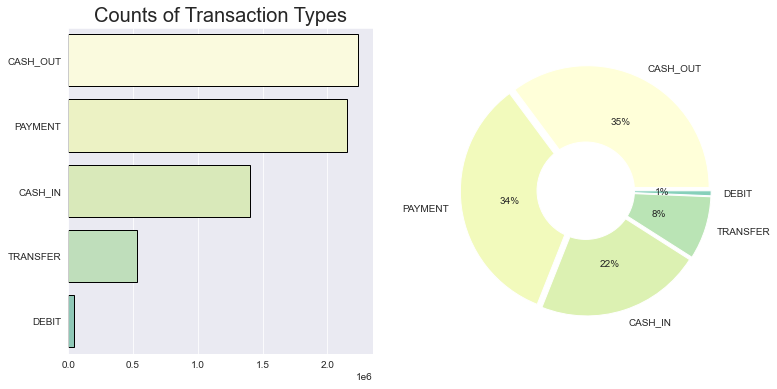

In [8]:
sns.set_style('darkgrid')
type_df = df['type'].value_counts()
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0] = sns.barplot(x=type_df.values, y=type_df.index, edgecolor="black",palette=col_def, ax=axes[0])
axes[0].set_title("Counts of Transaction Types", fontsize=20)
axes[1].pie(x= type_df[:10], labels = type_df.index, colors=col_def, autopct='%.0f%%',
           explode=[0.03 for i in type_df.index])
axes[1].add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

From the above we can see that `CASH_OUT` is the most used Transaction type. `Debit` is the least used

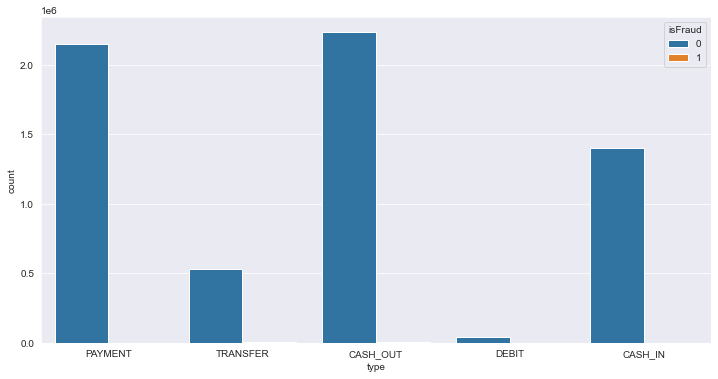

In [9]:
fig = plt.figure(figsize=(12, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.show()

From the above the plot seems to be showing that there are no positives for fraud which is not right! The reason for not showing up is that the amount of fraud data in the data set is very low when compared to the massive size of the whole dataset.

In [10]:
df['isFraud'].sum()

8213

As mentioned the number of fraudulent transactions are 8213, which is very small. To know exactly which types of transactions are responsible for frauds we can subset the data and find out.

In [11]:
fraud = []
for i in df.isFraud:
    if i == 1:
        fraud.append(i)
print(fraud[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [12]:
frauds = df.loc[df['isFraud'].isin(fraud)]
frauds.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


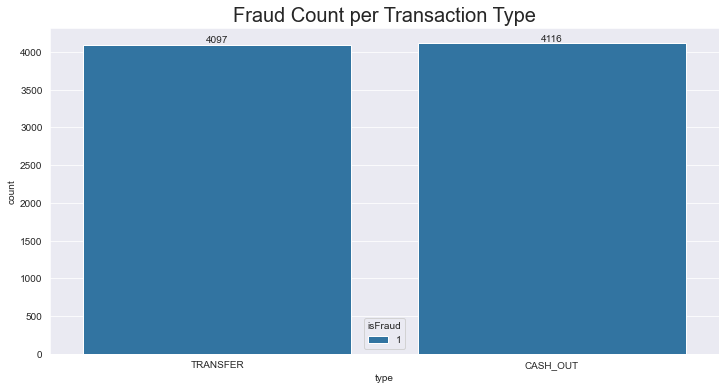

In [13]:
fig = plt.figure(figsize=(12, 6))
g = sns.countplot(x='type', hue='isFraud', data=frauds)
g.bar_label(g.containers[0])
plt.title("Fraud Count per Transaction Type", size=20)
plt.show()

From the above we can confirm that Transfer and cash_out types are the ones where frauds are occuring. 

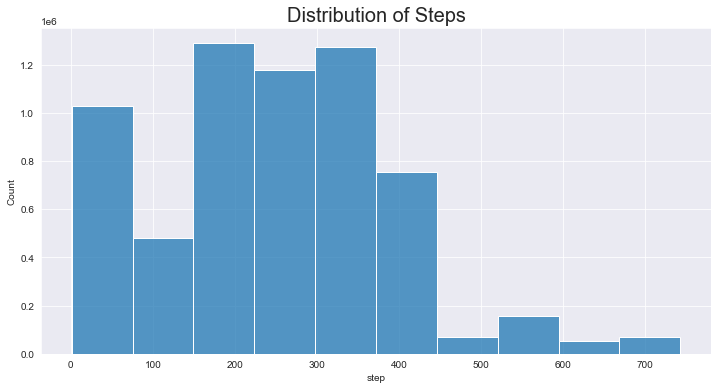

In [14]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(df['step'], bins=10)
plt.title("Distribution of Steps", size=20)
plt.show()

Now let's check whether there is any corelation between the variables

## Feature Selection

In [15]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [16]:
balance = df[['oldbalanceDest', 'newbalanceDest']]
balance.corr()

,oldbalanceDest,newbalanceDest
oldbalanceDest,1.000000,0.976569
newbalanceDest,0.976569,1.000000


The 'newbalanceDest', 'oldbalanceDest' have very high correlation. I will drop one of these columns. (I have done this in the modeling section)

In [17]:
balance2 = df[['oldbalanceOrg', 'newbalanceOrig']]
balance2.corr()

,oldbalanceOrg,newbalanceOrig
oldbalanceOrg,1.000000,0.998803
newbalanceOrig,0.998803,1.000000


The 'newbalanceOrig', 'oldbalanceOrg' have very high correlation. I will drop one of these columns.(I have done this in the modeling section)

## Data Cleaning

In [18]:
df.nameDest.unique()

array(['M1979787155', 'M2044282225', 'C553264065', ..., 'C1850423904',
       'C1881841831', 'C2080388513'], dtype=object)

In [19]:
merchant = []
for i in df.nameDest:
    if i[0] == 'M':
        merchant.append(i)
print(merchant[:30])
print(len(merchant))

['M1979787155', 'M2044282225', 'M1230701703', 'M573487274', 'M408069119', 'M633326333', 'M1176932104', 'M2096539129', 'M972865270', 'M801569151', 'M1635378213', 'M1731217984', 'M1877062907', 'M473053293', 'M1344519051', 'M1404932042', 'M1558079303', 'M58488213', 'M295304806', 'M33419717', 'M1940055334', 'M335107734', 'M1757317128', 'M1804441305', 'M1971783162', 'M151442075', 'M70695990', 'M1615617512', 'M107994825', 'M1426725223']
2151495


In [20]:
merchants = df.loc[df['nameDest'].isin(merchant)]
merchants.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


In [21]:
merchants.oldbalanceDest.unique()

array([0.])

In [22]:
merchants.newbalanceDest.unique()

array([0.])

In [23]:
merchants.isFraud.unique()

array([0], dtype=int64)

In [24]:
merchants.isFlaggedFraud.unique()

array([0], dtype=int64)

From the above we can confirm that there is no information on Merchant types as mentioned. To be precise this is the case when the merchant is the recepient of the money. We can remove the rows with no information.

In [25]:
new_df = df.loc[~df['nameDest'].isin(merchant)]
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1,0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0


In [26]:
new_df.shape

(4211125, 11)

## Encoding the Variables

In [27]:
le = LabelEncoder()
vars = ['type', 'nameOrig', 'nameDest']
for var in vars:
    new_df[var] = le.fit_transform(new_df[var])

In [28]:
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,3,181.00,663412,181.0,0.00,439685,0.0,0.00,1,0
3,1,1,181.00,3859208,181.0,0.00,391696,21182.0,0.00,1,0
9,1,2,5337.77,3580202,41720.0,36382.23,282960,41898.0,40348.79,0,0
10,1,2,9644.94,1958055,4465.0,0.00,571261,10845.0,157982.12,0,0
15,1,1,229133.94,4000507,15325.0,0.00,417183,5083.0,51513.44,0,0



Before going to do drop any of the columns mentioned above, let's us just split the model into train and test and fit it to the model. This is to see whether they have any impact on the model or not.

## Modeling

In [29]:
X = new_df.drop('isFraud', axis=1)
y = new_df['isFraud']

In [30]:
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X)
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 842225  842226  842227 ... 4211122 4211123 4211124] TEST: [     0      1      2 ... 842222 842223 842224]
TRAIN: [      0       1       2 ... 4211122 4211123 4211124] TEST: [ 842225  842226  842227 ... 1684447 1684448 1684449]
TRAIN: [      0       1       2 ... 4211122 4211123 4211124] TEST: [1684450 1684451 1684452 ... 2526672 2526673 2526674]
TRAIN: [      0       1       2 ... 4211122 4211123 4211124] TEST: [2526675 2526676 2526677 ... 3368897 3368898 3368899]
TRAIN: [      0       1       2 ... 3368897 3368898 3368899] TEST: [3368900 3368901 3368902 ... 4211122 4211123 4211124]


In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

In [32]:
m = KNeighborsClassifier()
m.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
y_pred = m.predict(X_test)

In [34]:
print("accuracy is : ",accuracy_score(y_test,y_pred))
print("precision score is : ",precision_score(y_test,y_pred))
print("recall score is : ",recall_score(y_test,y_pred))

accuracy is :  0.9974923565555522
precision score is :  0.9949215143120961
recall score is :  0.5063439849624061


In [35]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[837958,     11],
       [  2101,   2155]], dtype=int64)

In [36]:
m.score(X_test, y_test)

0.9974923565555522

As you can see the model is giving a score of 0.9, Now let's drop the `newbalanceOrig`, `oldbalanceDest`. This is to see whether they are having any impact on the model or not

In [37]:
df_copy = new_df.copy() #copying the new_df

In [38]:
df_copy.drop(['newbalanceOrig', 'oldbalanceDest'], axis=1, inplace=True) #dropping the cols

In [39]:
X_cp = df_copy.drop('isFraud', axis=1)
y_cp = df_copy['isFraud']

In [40]:
for train_index, test_index in kf.split(X_cp,y_cp):
    print("TRAIN COPY:", train_index, "TEST COPY:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN COPY: [ 842225  842226  842227 ... 4211122 4211123 4211124] TEST COPY: [     0      1      2 ... 842222 842223 842224]
TRAIN COPY: [      0       1       2 ... 4211122 4211123 4211124] TEST COPY: [ 842225  842226  842227 ... 1684447 1684448 1684449]
TRAIN COPY: [      0       1       2 ... 4211122 4211123 4211124] TEST COPY: [1684450 1684451 1684452 ... 2526672 2526673 2526674]
TRAIN COPY: [      0       1       2 ... 4211122 4211123 4211124] TEST COPY: [2526675 2526676 2526677 ... 3368897 3368898 3368899]
TRAIN COPY: [      0       1       2 ... 3368897 3368898 3368899] TEST COPY: [3368900 3368901 3368902 ... 4211122 4211123 4211124]


In [41]:
# X_train, X_test, y_train, y_test = train_test_split(X_cp, y_cp, test_size=0.2, random_state=42, stratify=y)

In [42]:
m1 = KNeighborsClassifier()
m1.fit(X_train, y_train)
m1.score(X_test, y_test)

0.9974923565555522

In [43]:
print("accuracy is : ",accuracy_score(y_test,y_pred))
print("precision score is : ",precision_score(y_test,y_pred))
print("recall score is : ",recall_score(y_test,y_pred))

accuracy is :  0.9974923565555522
precision score is :  0.9949215143120961
recall score is :  0.5063439849624061


In [44]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[837958,     11],
       [  2101,   2155]], dtype=int64)

After removing the the variables `'newbalanceOrig'`, `'oldbalanceDest'` the score is still the same. So it is working fine

I also would like to see how the RandomForestClassifier() works for this.

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
rf.score(X_train, y_train)

0.9999997031672059

In [47]:
rf.score(X_test, y_test)

0.9986713764136662

The RandomForestClassifier is working great as well for this data. Moreover it is giving a little bit more accuracy than KNN.

### 1. Data cleaning including missing values, outliers and multi-collinearity.

When it comes to data cleaning, the only thing that I had to deal with missing values. As the data dictionary mentioned, only the merchant data was missing which I dropped. I wanted to be sure so I even checked whether it was true or not. I did not come across any outliers or multi-collinearity in the data.

### 2. Describe your fraud detection model in elaboration.

For fraud detection I experimented with 2 models. They are:
* KNN
* RandomForestClassifier

Both the models work with the cross validated data which was done using `KFold` cross validation. Both of them gave a score of `0.9` but if compared closely RandomForestClassifier is working better(0.9999997031672059). So I am going to be taking `RandomForestClassifier` as my `final model`.

### 3. How did you select variables to be included in the model?

I used `.corr()` to find the pairwise correlation between the variables. I found out that `newbalanceDest`, `oldbalanceDest` and `newbalanceOrig`, `oldbalanceOrg` are having high correlation (0.97 & 0.99 respectively). I even made sure that the model is doing fine even if they are not present in the data (shown above).  Using this method I `selected` the remaining variables to be included. 

### 4. Demonstrate the performance of the model by using best set of tools.

The model performed well considering the fact that it had a lot of data. Also, due to performing `KFold cross validation` the model was able to give a very `good accuracy` and `precision`. The `recall` is not that bad either considering that the `positives` available for fraud in the dataset is `very less`. Overall the model did a fine job on predicting whether the transaction was fraud or not.

### 5. What are the key factors that predict fraudulent customer?

In [48]:
rf.feature_importances_

array([7.07112675e-02, 1.64943171e-01, 1.33224877e-01, 3.19696889e-02,
       2.48073204e-01, 5.06180766e-02, 3.05758378e-02, 7.80325099e-02,
       1.91611255e-01, 2.40112369e-04])

In [49]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

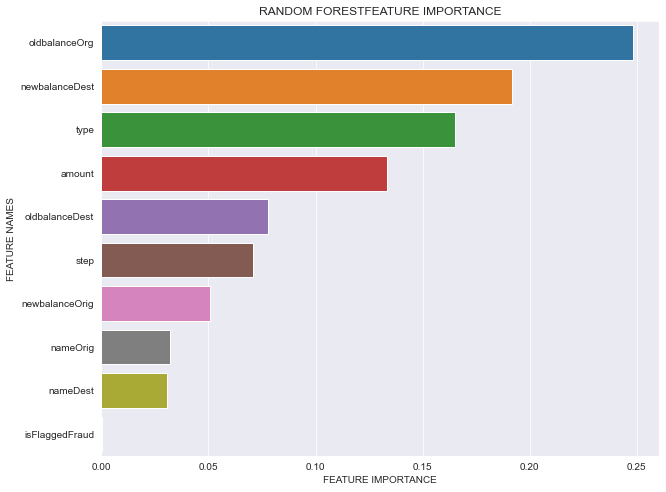

In [50]:
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST')

As you can see the columns that I dropped had less of an importance. I will try the same with the remaining 3 namely `nameOrig`, `nameDest` and `isFlaggedFraud`

In [51]:
df_copy.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [52]:
df_copy.head()

,step,type,amount,oldbalanceOrg,newbalanceDest,isFraud
2,1,3,181.00,181.0,0.00,1
3,1,1,181.00,181.0,0.00,1
9,1,2,5337.77,41720.0,40348.79,0
10,1,2,9644.94,4465.0,157982.12,0
15,1,1,229133.94,15325.0,51513.44,0


In [53]:
X_1 = df_copy.drop('isFraud', axis=1)
y_1 = df_copy['isFraud']
for train_index, test_index in kf.split(X_1,y_1):
    print("TRAIN COPY:", train_index, "TEST COPY:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN COPY: [ 842225  842226  842227 ... 4211122 4211123 4211124] TEST COPY: [     0      1      2 ... 842222 842223 842224]
TRAIN COPY: [      0       1       2 ... 4211122 4211123 4211124] TEST COPY: [ 842225  842226  842227 ... 1684447 1684448 1684449]
TRAIN COPY: [      0       1       2 ... 4211122 4211123 4211124] TEST COPY: [1684450 1684451 1684452 ... 2526672 2526673 2526674]
TRAIN COPY: [      0       1       2 ... 4211122 4211123 4211124] TEST COPY: [2526675 2526676 2526677 ... 3368897 3368898 3368899]
TRAIN COPY: [      0       1       2 ... 3368897 3368898 3368899] TEST COPY: [3368900 3368901 3368902 ... 4211122 4211123 4211124]


In [54]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9986654397577844

As you can see the model is doing fine.

### 6. Do these factors make sense? If yes, How? If not, How not?

Yes, the do make sense. Since the `newbalanceDest`, `oldbalanceDest` and `newbalanceOrig`, `oldbalanceOrg` had high `correlation` it would make sence even if `2` of those (newbalanceOrig, oldbalanceDest) were dropped the model would perform the same. For the other 3 ('nameOrig' 'nameDest' 'isFlaggedFraud') as well, after they are dropped the model was working fine. This is because, the model need not know who the `sender` and who the `receiver` is because any one of those two can get be subjected to fraud, worst case both of them can also be subjected to fraud. The only thing we need is here is the `pattern of cash flow` occuring in the case of `fraud`. Coming to `isFlaggedFraud` it did not serve any purpose since many of the transactions were `greater than 200000` and most of them were not even fraud. That is the reason why I dropped those 5 variables from the dataset.

### 7. What kind of prevention should be adopted while company update its infrastructure?

We've seen above that most of the frauds occured in case of the `CASH-OUT` and `TRANSFER`. This does not mean that it is limited to only those two types. So, what we can do is that we should put a `limit` on how much `amount` one can `take out` from his account `at once`. By doing this if some one ever tries to go `beyond the limit` we can be `notified` of that `transaction` and make sure that it does not happen. We can enquire the account holder of the deails of that take out and confirm if it was by the owner or some third party.`2 step verification` particularly for `taking out` the cash can also be done for the sake of safety.

### 8. Assuming these actions have been implemented, how would you determine if they work?

If the above mentioned are implemented as it is, they would be `notified` when ever someone tries to transact or get the money `over the limit` set. If `2 step verification` is implemented only the owner can get that `passcode/OTP` so if it is not the owner he can notify the company immediately.